In [1]:
import sys
! pip install -U spacy
! python -m spacy download en
! pip install spacy
! pip install spacymoji
! pip install emoji
! pip install scikit-learn
! pip install gensim
! pip install sklearn
! pip install matplotlib
! pip install wordcloud


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     --------------------------------------- 12.8/12.8 MB 24.2 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use
the full pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import spacy
import emoji
import numpy as np
from tqdm import tqdm

from sklearn.cluster import DBSCAN
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.test.utils import get_tmpfile

In [3]:
#datsetPath = '../Datasets/corto.csv'
#datsetPath = '../Datasets/SuicideDetection.csv'
datsetPath = '../Datasets/Suicide_Detection20000.csv'

data = pd.read_csv(datsetPath)

textos = []
for instancia in data.values:
    textos.append(instancia[1])

In [4]:
# Cuidado! La ejecución de este bloque con 232074 instancias, toma aproximademente 5 min?

nlp = spacy.load("en_core_web_sm") # Cargar modelo
nlp.add_pipe("emoji", first=True)

textos_tokenizados = []
for texto in tqdm(textos, desc="Procesando textos"):
    texto = emoji.demojize(texto)  # Emojis a texto
    texto = texto.replace(':', ' ').replace('filler', ' ').replace('filer', ' ').replace('_', ' ')
    doc = nlp(texto)
    lexical_tokens = [token.lemma_.lower() for token in doc if len(token.text) > 3 and token.is_alpha]
    textos_tokenizados.append(lexical_tokens)

Procesando textos: 100%|██████████| 20000/20000 [07:58<00:00, 41.79it/s]


In [5]:
#with open("tokens.tok", "w", encoding="utf-8") as file:
 #   for token in doc:
  #      file.write(token.text + "\n")

In [6]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(textos_tokenizados)]
model = Doc2Vec(documents, vector_size=150, window=2, dm=1, epochs=100, workers=4)

model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

model.save(get_tmpfile("my_doc2vec_model"))


In [7]:
document_vectors = [model.infer_vector(doc) for doc in textos_tokenizados]
print(document_vectors[1])

[-7.5911969e-01 -3.9589605e-01 -5.1255459e-01 -6.9891161e-01
 -2.2266434e-01  1.1493785e+00 -3.9408383e-01  9.1975546e-01
 -4.2255810e-01  8.7545052e-02  1.3831941e+00 -5.2497339e-01
  1.0566316e+00  1.2091480e-01  3.8210461e-01 -1.8363166e-01
  8.6865827e-02 -1.0974611e+00 -5.3610331e-01  1.7023158e-01
  5.7431078e-01 -1.9730189e-01  8.3109683e-01  7.3805332e-01
  2.0448764e-01  1.9726992e-01  4.3150306e-01 -4.8613980e-01
 -1.3005894e-01  6.0109608e-02 -1.0028389e+00  1.0497346e-02
  1.4246234e+00  4.9076232e-01  4.1944683e-01 -4.0937358e-01
  1.1920307e+00  1.3135931e+00  7.2005039e-01  7.8754082e-02
 -4.3923673e-01  7.6858532e-01  7.5993937e-01 -5.0414962e-01
  2.2345752e-01  1.6381475e-01 -1.0592730e+00 -3.4094179e-01
  7.3020709e-01 -1.3394371e+00 -5.2560657e-01 -2.7901065e-01
 -4.4442892e-01  8.2583374e-01 -1.7233124e-01  3.3619276e-01
  7.4121457e-01  2.3401798e-01  1.1962953e+00 -8.8000959e-01
 -4.2029339e-01  5.0318509e-01 -1.4270575e+00  5.2085567e-01
 -3.3598134e-01 -3.63656

In [8]:
#import csv
#file_name = "vectoresDoc.tsv"
#with open(file_name, 'w', newline='') as tsvfile:
 #   writer = csv.writer(tsvfile, delimiter='\t')
  #  for vector in document_vectors:
   #     writer.writerow(vector)

In [9]:
epsilon = 5
minP = 10

# Con el corto:
#epsilon = 7
#minP = 2

In [10]:
import numpy as np

vecinos = []
nucleos = []
#alcanzables = []

for i, doc in enumerate(document_vectors):
    v = []
    for j, doc2 in enumerate(document_vectors):
        distEuc = np.linalg.norm(doc - doc2)
        if distEuc <= epsilon:
            v.append((j,doc2))
    vecinos.append(v)
    if len(v) >= minP:
        nucleos.append((i, doc))


print(f'Tenemos un total de {len(document_vectors)} instancias, de las cuales son:'
      f'\\\nNúcleos: {len(nucleos)}')

#print(f' Nuestros núcleos son: \n {nucleos}')

Tenemos un total de 20000 instancias, de las cuales son:\
Núcleos: 2200


In [11]:
clusters = []
numCluster = -1
for i in range(len(document_vectors)):
    clusters.append(-1)

nucleosPorVisitar = []
for i, nucleo in nucleos:
    if clusters[i] == -1:
        numCluster += 1
        clusters[i] = numCluster
        nucleosPorVisitar.append((i, nucleo))
        while nucleosPorVisitar:
            j, nucleo_actual = nucleosPorVisitar.pop()
            for index, vecino in vecinos[j]:
                if clusters[index] == -1:
                    clusters[index] = numCluster
                    if (j, nucleo_actual) in nucleos:
                        nucleosPorVisitar.append((j, nucleo_actual))
print(clusters)

[-1, -1, -1, 0, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 4, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, 0, -1, -1, -1, -1, 0, -1, -1, 7, -1, -1, -1, -1, -1, -1, -1, -1, 8, -1, -1, 0, 9, 10, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 11, -1, -1, -1, 12, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, 14, 15, -1, -1, -1, -1, -1, -1, -1, -1, 16, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, 17, -1, -1, -1, -1, 0, -1, -1, -1

In [12]:
clusters_válidos=[]
alcanzables = []
for c in range(numCluster+1):
    if clusters.count(c)<minP:
        for i, clus in enumerate(clusters):
            if clus == c:
                alcanzables.append((i, vecinos[i]))
    else:
        clusters_válidos.append(c)
print(len(clusters_válidos))
print(clusters_válidos)

21
[0, 2, 5, 6, 7, 9, 11, 12, 13, 15, 17, 22, 23, 44, 45, 46, 49, 52, 53, 75, 135]


In [13]:
for i, vecinos in alcanzables:
    previo = clusters[i]
    for j, v in vecinos:
        if clusters[j] in clusters_válidos:
            clusters[i] = clusters[j]
    if previo == clusters[i]:
        clusters[i]=-1

In [14]:
for i in range(len(clusters_válidos)):
    for j in range(len(clusters)):
        if clusters[j] == clusters_válidos[i]: clusters[j] = i

In [15]:
extras = 1
if min(clusters)==-1 : extras = 2
total = 0
for cluster in range(min(clusters), max(clusters)+1):
    kont = 0
    for i in clusters:
        if i == cluster:
            kont += 1
    if cluster == -1:
        print(f'Hay un total de {kont} instancias que son ruido')
    else:
        print(f'Del cluster {cluster} hay {kont} instancias')
    total = total + kont


Hay un total de 17750 instancias que son ruido
Del cluster 0 hay 1754 instancias
Del cluster 1 hay 12 instancias
Del cluster 2 hay 39 instancias
Del cluster 3 hay 20 instancias
Del cluster 4 hay 15 instancias
Del cluster 5 hay 34 instancias
Del cluster 6 hay 12 instancias
Del cluster 7 hay 25 instancias
Del cluster 8 hay 23 instancias
Del cluster 9 hay 10 instancias
Del cluster 10 hay 58 instancias
Del cluster 11 hay 48 instancias
Del cluster 12 hay 39 instancias
Del cluster 13 hay 46 instancias
Del cluster 14 hay 14 instancias
Del cluster 15 hay 19 instancias
Del cluster 16 hay 15 instancias
Del cluster 17 hay 25 instancias
Del cluster 18 hay 10 instancias
Del cluster 19 hay 19 instancias
Del cluster 20 hay 13 instancias


In [16]:

for c in range(-1, max(clusters)+1):
    kont=0
    print(f'\n\n\n################################CLUSTER NUMERO {c}################################\n\n\n')
    for i, clus in enumerate(clusters):
        if clus==c and kont<5:
            print(textos[i])
            print('\n\n\n')
            kont+=1
print(len(clusters))





################################CLUSTER NUMERO -1################################



Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen.




Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it




Finally 2020 is almost over... So I can never hea

In [17]:
print(data)
clases = data['class'].copy()
print(len(clases))
nombres_clases=['suicide', 'non-suicide']
class_to_cluster = []
for i in range(len(clusters_válidos)):
    class_to_cluster.append([0,0])
print(len(clusters))
for i, c in enumerate(clusters):
    if c != -1:
        if clases[i].__eq__('suicide'):
            class_to_cluster[c][0] += 1
        else:
            class_to_cluster[c][1] += 1
print(i)
print(class_to_cluster)

       Unnamed: 0                                               text  \
0               2  Ex Wife Threatening SuicideRecently I left my ...   
1               3  Am I weird I don't get affected by compliments...   
2               4  Finally 2020 is almost over... So I can never ...   
3               8          i need helpjust help me im crying so hard   
4               9  I’m so lostHello, my name is Adam (16) and I’v...   
...           ...                                                ...   
19995       30118  I just wish I wasn't like thisI read a lot of ...   
19996       30119  Future druggie?Why do i see the only reason to...   
19997       30121  I just tried to kill myself. Help.I just tried...   
19998       30122  Someone downvoted my post about me being a pie...   
19999       30123  Here's a question: If a straight guy dates a g...   

             class  
0          suicide  
1      non-suicide  
2      non-suicide  
3          suicide  
4          suicide  
...      

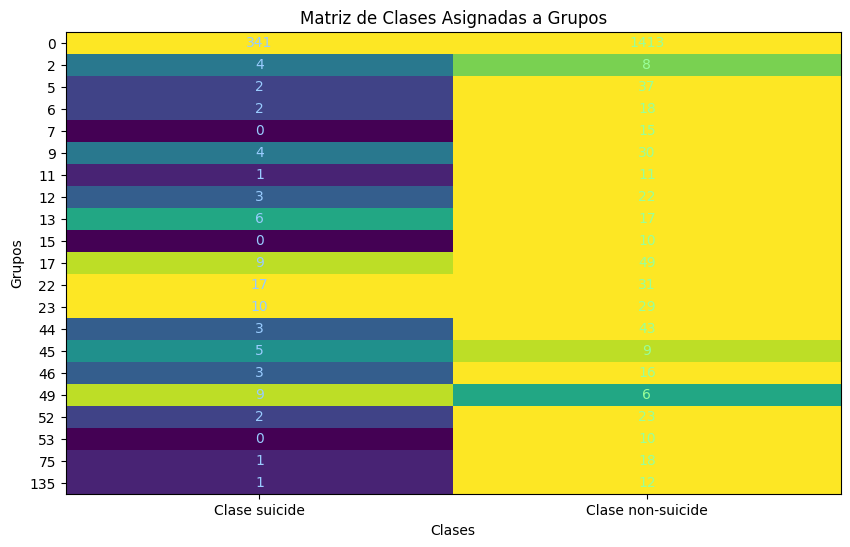

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que tienes 20 grupos y 2 clases
num_groups = len(clusters_válidos)
num_classes = len(nombres_clases)
# Crear una matriz de ejemplo con las instancias de clases en cada grupo
# Esto es solo un ejemplo, debes proporcionar tus datos reales

# Definir colores personalizados (azul y verde claros)
light_blue = (0.6, 0.8, 1.0)  # Color azul claro
light_green = (0.6, 1.0, 0.6)  # Color verde claro

# Crear una figura y mostrar la matriz con los colores personalizados
plt.figure(figsize=(10, 6))
plt.imshow(class_to_cluster, cmap='viridis', aspect='auto', interpolation='nearest', vmin=0, vmax=10)

# Personalizar el eje x y el eje y para mostrar los grupos y las clases
plt.xticks(range(num_classes), [f'Clase {nombres_clases[i]}' for i in range(num_classes)])
plt.yticks(range(num_groups), [f'{clusters_válidos[i]}' for i in range(num_groups)])

# Usar los colores personalizados para mostrar la matriz
for i in range(num_groups):
    for j in range(num_classes):
        plt.text(j, i, class_to_cluster[i][j], ha='center', va='center', color=light_blue if j == 0 else light_green)

# Etiquetas para los ejes
plt.xlabel("Clases")
plt.ylabel("Grupos")

plt.title("Matriz de Clases Asignadas a Grupos")
plt.show()



In [19]:
palabras_del_cluster = []
for c in range(-1, max(clusters)+1):
    palabras_c = ' '
    for i, clus in enumerate(clusters):
        if clus==c:
            t = ' '.join(textos_tokenizados[i])
            palabras_c = palabras_c + ' ' + t
    palabras_del_cluster.append(palabras_c)




###################################CLUSTER -1##########################################





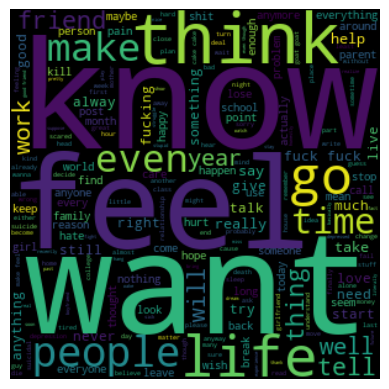




###################################CLUSTER 0##########################################





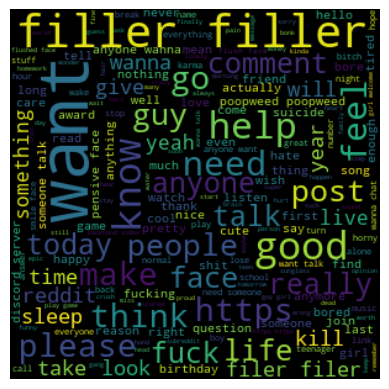




###################################CLUSTER 1##########################################





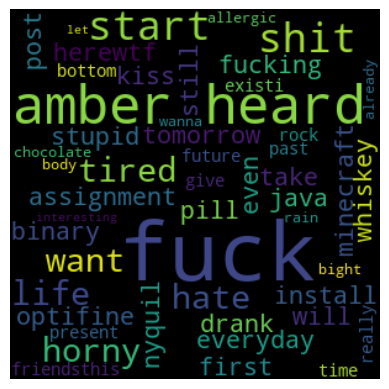




###################################CLUSTER 2##########################################





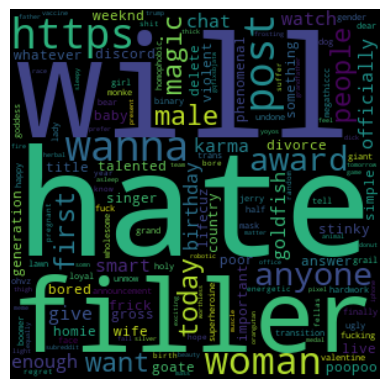




###################################CLUSTER 3##########################################





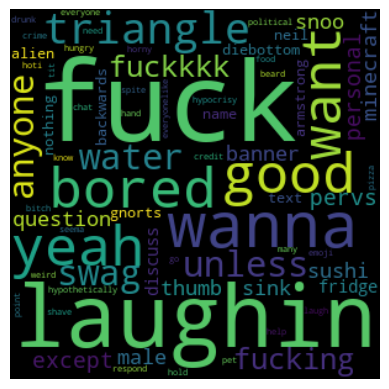




###################################CLUSTER 4##########################################





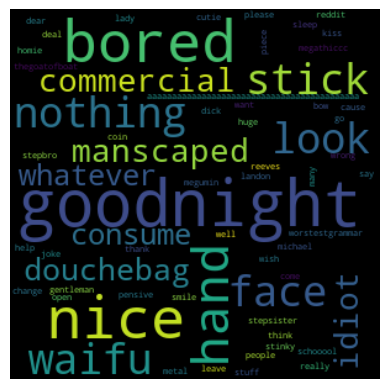




###################################CLUSTER 5##########################################





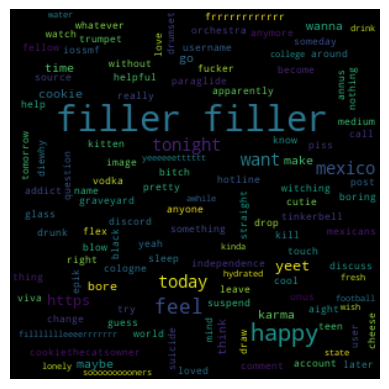




###################################CLUSTER 6##########################################





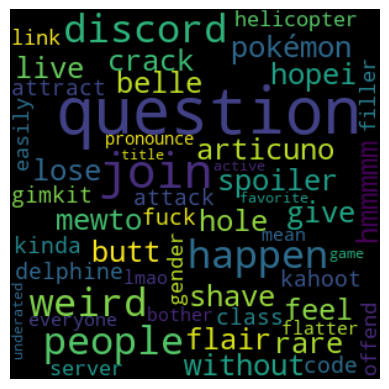




###################################CLUSTER 7##########################################





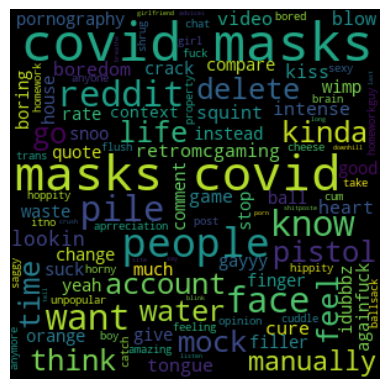




###################################CLUSTER 8##########################################





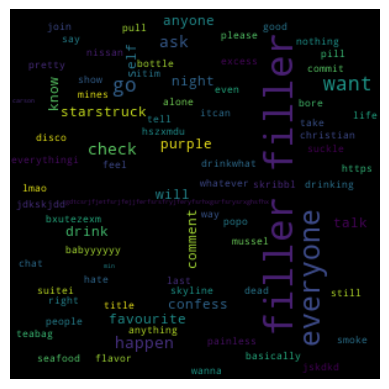




###################################CLUSTER 9##########################################





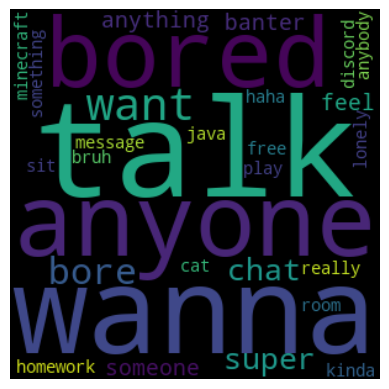




###################################CLUSTER 10##########################################





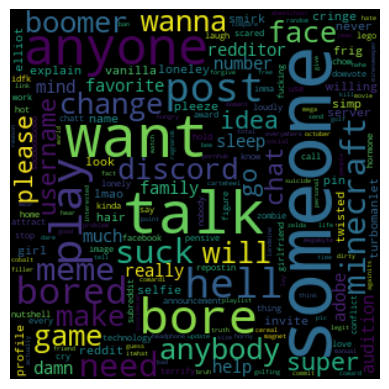




###################################CLUSTER 11##########################################





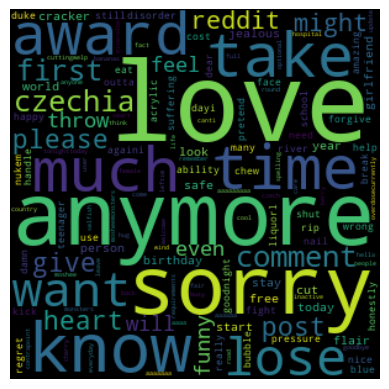




###################################CLUSTER 12##########################################





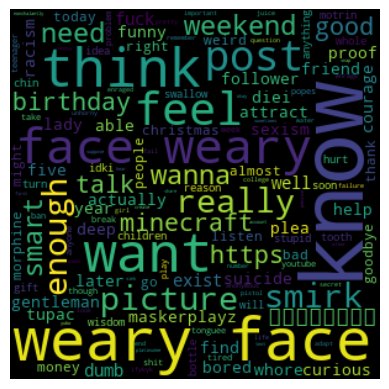




###################################CLUSTER 13##########################################





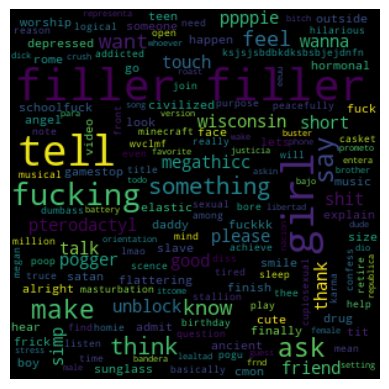




###################################CLUSTER 14##########################################





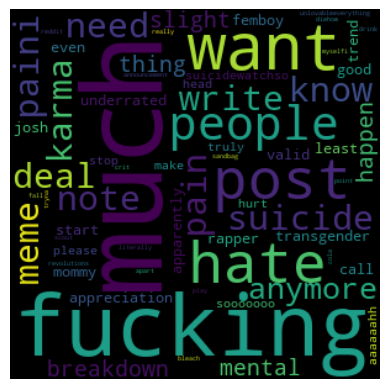




###################################CLUSTER 15##########################################





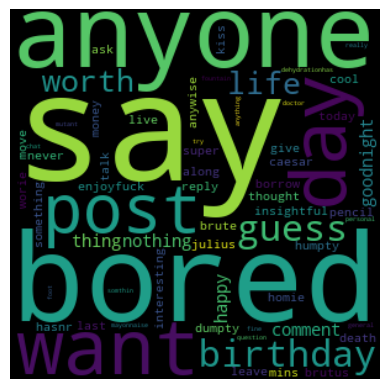




###################################CLUSTER 16##########################################





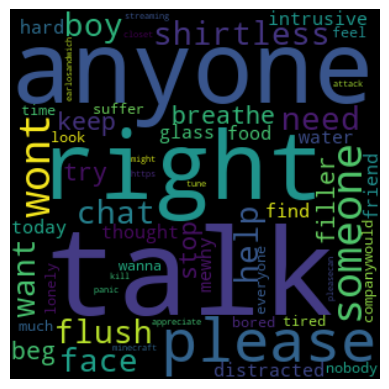




###################################CLUSTER 17##########################################





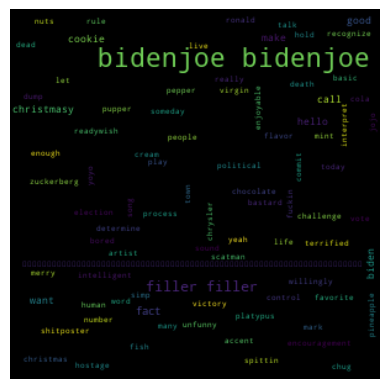




###################################CLUSTER 18##########################################





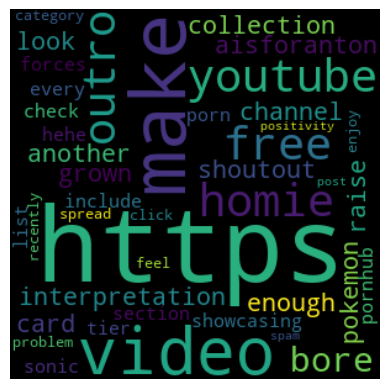




###################################CLUSTER 19##########################################





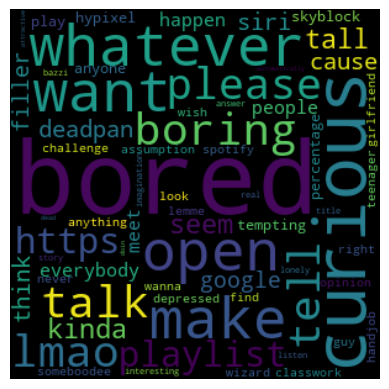




###################################CLUSTER 20##########################################





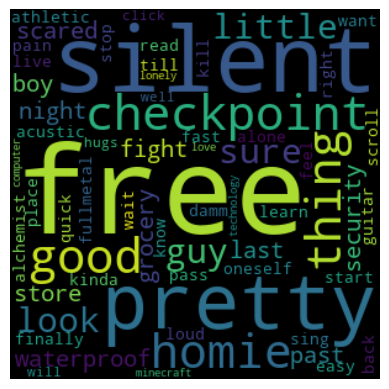

In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for i in range(len(palabras_del_cluster)):
    print(f'\n\n\n###################################CLUSTER {i-1}##########################################\n\n\n')
    wc = WordCloud(width = 300, height= 300).generate(palabras_del_cluster[i])
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.show()

In [21]:

from mpl_toolkits.mplot3d import Axes3D  # Necesario para gráficos 3D

def plot_samples(samples, n_dimensiones, X_train_space, cluster_labels):
    if n_dimensiones == 2:
        # Dibujar los puntos en el espacio, color: cluster
        plt.scatter(X_train_space[:samples, 0], X_train_space[:samples, 1], cmap=plt.cm.get_cmap('nipy_spectral', 10), c=cluster_labels[:samples])
        plt.colorbar()
    elif n_dimensiones == 3:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(X_train_space[:samples, 0], X_train_space[:samples, 1], X_train_space[:samples, 2], cmap='viridis', c=cluster_labels[:samples])
        plt.legend(*sc.legend_elements(), title="Clases")
        # Mostrar la gráfica en 3D
        plt.show()
    else:
        pass

# Llama a la función plot_samples con tus datos y la cantidad de instancias a mostrar
# plot_samples(samples, n_dimensiones, X_train_space)


Dim after PCA:  (20000, 2)


C:\Users\Sergio\AppData\Local\Temp\ipykernel_15504\1128388079.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_train_space[:samples, 0], X_train_space[:samples, 1], cmap=plt.cm.get_cmap('nipy_spectral', 10), c=cluster_labels[:samples])


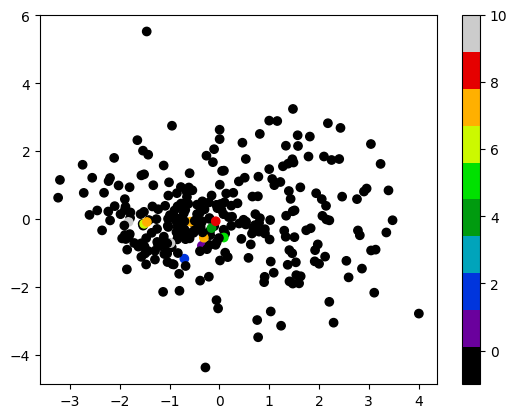

In [22]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
n_dimensiones= 2
pca = PCA(n_components=n_dimensiones, random_state=42)
pca.fit(document_vectors)
# Cambio de base a dos dimensiones PCA
X_train_PCAspace = pca.transform(document_vectors)
print('Dim after PCA: ',X_train_PCAspace.shape)
plot_samples(300, n_dimensiones, X_train_PCAspace, clusters)

In [23]:
# Aplicar DBSCAN a los vectores de documentos
dbscan = DBSCAN(eps=epsilon, min_samples=minP)  # Ajusta los parámetros según tu caso
model=dbscan.fit(document_vectors)
cluster_labels = dbscan.fit_predict(document_vectors)

# Los resultados del clustering están en 'labels'
print("Etiquetas de clusters:", cluster_labels)

Etiquetas de clusters: [-1 -1 -1 ... -1 -1 -1]


In [24]:
extras = 1
if min(cluster_labels)==-1 : extras = 2
total = 0
for cluster in range(min(cluster_labels), max(cluster_labels)+1):
    kont = 0
    for i in cluster_labels:
        if i == cluster:
            kont += 1
    if cluster == -1:
        print(f'Hay un total de {kont} instancias que son ruido')
    else:
        print(f'Del cluster {cluster} hay {kont} instancias')
    total = total + kont


Hay un total de 17196 instancias que son ruido
Del cluster 0 hay 2804 instancias


Dim after PCA:  (20000, 2)


C:\Users\Sergio\AppData\Local\Temp\ipykernel_15504\1128388079.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_train_space[:samples, 0], X_train_space[:samples, 1], cmap=plt.cm.get_cmap('nipy_spectral', 10), c=cluster_labels[:samples])


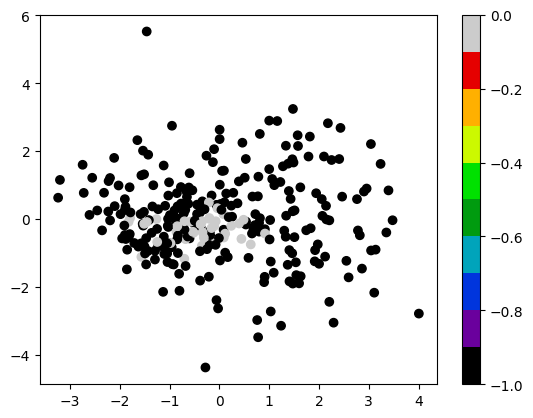

In [25]:
from sklearn.decomposition import PCA
n_dimensiones= 2
pca = PCA(n_components=n_dimensiones, random_state=42)
pca.fit(document_vectors)
# Cambio de base a dos dimensiones PCA
X_train_PCAspace = pca.transform(document_vectors)
print('Dim after PCA: ',X_train_PCAspace.shape)
plot_samples(300, n_dimensiones, X_train_PCAspace, cluster_labels)